In [1]:
# 필요 패키지 임포트
import os
import cv2
from PIL import Image
import tensorflow as tf

In [2]:
from keras.applications import vgg16

# VGG16 모델 불러오기
model = vgg16.VGG16()

# 모델 구조 확인
model.summary()

553467096/553467096 [==============================] - 22s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

## 학습데이터 부족 극복을 위한 이미지 제너레이터 생성

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/drive/MyDrive/Colab Notebooks/Plastic on Sand/Train'
validation_dir = '/content/drive/MyDrive/Colab Notebooks/Plastic on Sand/Test'
batch_size = 32
image_size = 224

# 학습에 사용될 이미지 데이터 생성기
train_datagen = ImageDataGenerator(
      rotation_range=180, # 회전 쵀대 20도
      width_shift_range=0.2, # 좌우 이동
      height_shift_range=0.2, # 상하 이동
      horizontal_flip=True, # 좌우 반전
      vertical_flip=True, # 상하 반전
      )
 
# # 검증에 사용될 이미지 데이터 생성기
validation_datagen = ImageDataGenerator()
 

# 학습에 사용될 데이터 생성기  
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary', # 이중 분류를 위한 binary mode
        shuffle=True)

# # 검증에 사용될 데이터 생성기
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

class_num=len(train_generator.class_indices)

custom_labels = list(validation_generator.class_indices.keys())


Found 122 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [4]:
# 커스텀 레이블 자동생성확인
print(custom_labels)

['Clean', 'Dirt']


In [5]:
# 모델을 원하는 조건대로 불러온 후 기존 학습
pre_trained_model = vgg16.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# 기존 학습 레이어 freeze
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False

58889256/58889256 [==============================] - 3s 0us/step
input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [6]:
# 커스텀 레이어 이중 분류에 맞게 추가
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2, activation='sigmoid')(x)

In [7]:
model = tf.keras.Model(pre_trained_model.input, x)

In [8]:
# 모델 컴파일 : 옵티마이져는 아담, loss함수는 정수레이블일때 사용하는 sparse_categorical_crossentropy
model.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
# 학습시작
vgg_classifier = model.fit(train_generator, 
                           epochs = 5,
                           validation_data=validation_generator,
                           batch_size = batch_size,
                           verbose = 1)

Epoch 1/5
4/4 [==============================] - 134s 33s/step - loss: 31.9935 - acc: 0.5246 - val_loss: 3.3979 - val_acc: 0.8667
Epoch 2/5
4/4 [==============================] - 107s 29s/step - loss: 22.9126 - acc: 0.5902 - val_loss: 10.9840 - val_acc: 0.7000
Epoch 3/5
4/4 [==============================] - 102s 28s/step - loss: 6.1023 - acc: 0.8033 - val_loss: 2.6754 - val_acc: 0.9000
Epoch 4/5
4/4 [==============================] - 105s 26s/step - loss: 5.1523 - acc: 0.8443 - val_loss: 6.8916 - val_acc: 0.8333
Epoch 5/5
4/4 [==============================] - 97s 26s/step - loss: 5.0652 - acc: 0.8279 - val_loss: 2.6295 - val_acc: 0.9000


In [11]:
# 모델 테스트용 패키지 임포트
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from IPython.display import display #이미지 출력 함수 
import numpy as np

In [12]:
def classify_image(path):
    # 이미지 파일을 읽고 화면에 표시
    image = load_img(path)
    # image = PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=688x550
    display(image)

    # 모델 사이즈로 이미지 파일을 읽기
    image = load_img(path, target_size=(224, 224))
    # image = PIL.Image.Image image mode=RGB size=224x224

    
    # 이미지 데이터를 numpy로 변환
    image = img_to_array(image)
    # [
    #   [[211. 184. 163.]
    #   [225. 193. 170.]
    #   ...
    #   [237. 202. 180.]]
    #   ...
    # ]  
    #
    # image.shape = (224, 224, 3)

    # vgg16.preprocess_input()을 호출하기 위해 차원을 조정
    # 보통 모델을 여러 이미지를 한번에 호출. 
    # 맨 앞의 1 : 이미지 갯수가 1개라는 것.
    # 두번째 224 : 가로
    # 세번째 224 : 세로
    # 네번째 3 : R, G, B 3개
    image = image.reshape((1, 224, 224, 3))

    # VGG16 모델 호출을 위해 데이터 전처리.
    # -255 ~ 255 사이 값으로 정규화한다.
    # 그리고 RGB를 BGR순으로 바꾼다.
    image = vgg16.preprocess_input(image)
    
    
    # 이미지를 모델에 적용
    yhat = model.predict(image)

    if yhat.argmax() == 0 : 
        print('clean')
    else: 
        print('dirt')

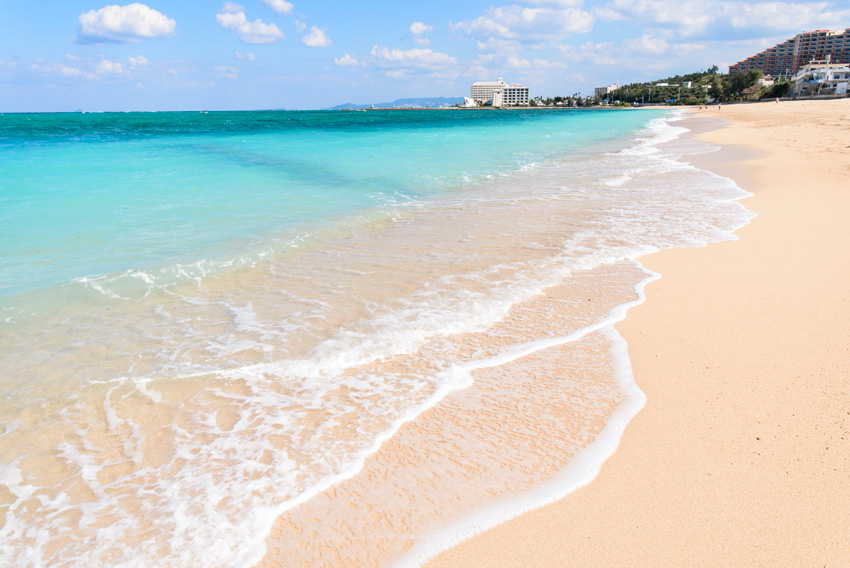

1/1 [==============================] - 1s 1s/step
clean


In [13]:
classify_image('/content/clean.jpeg')

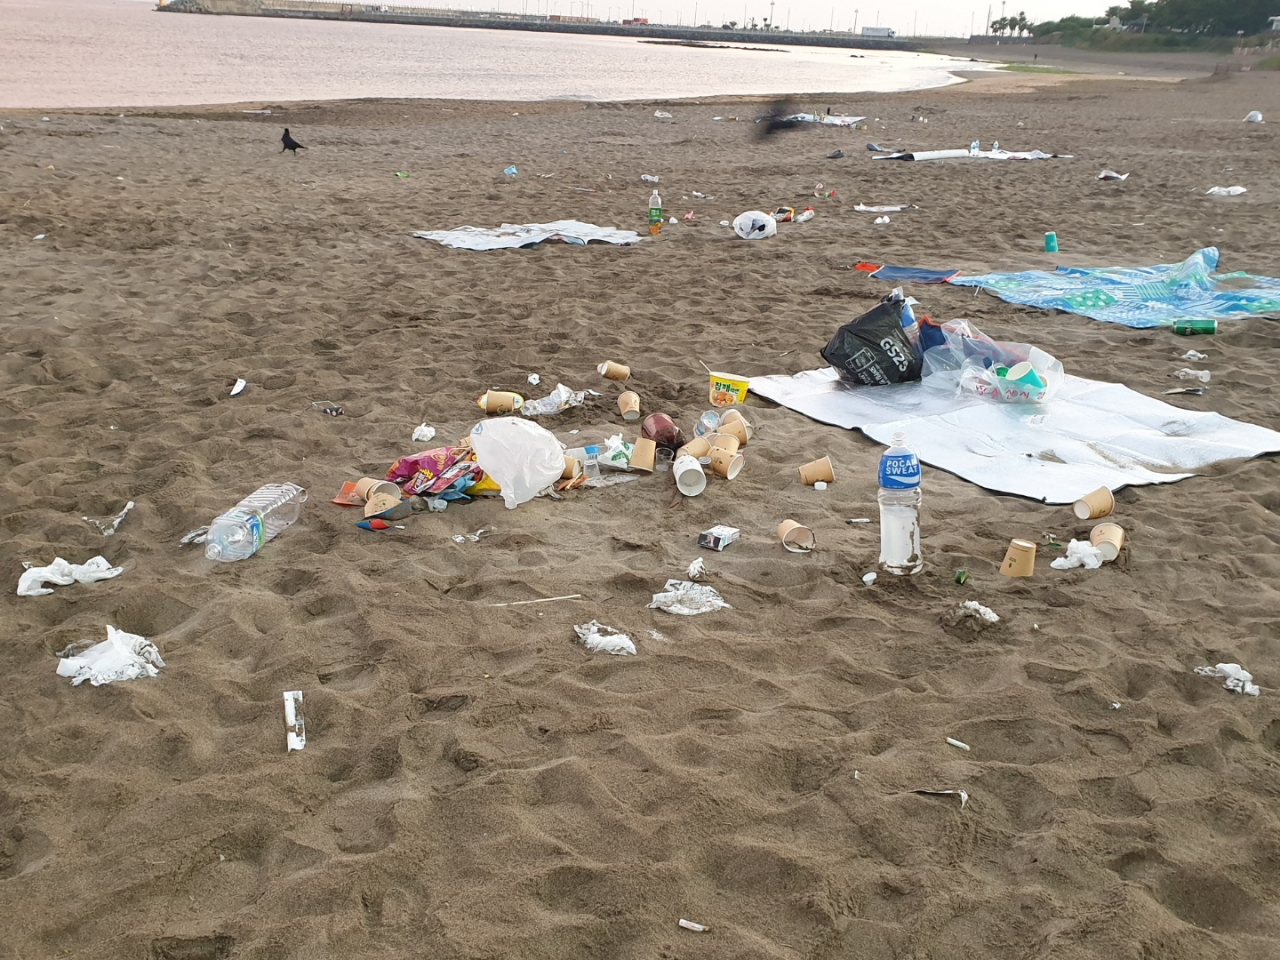

1/1 [==============================] - 1s 780ms/step
dirt


In [14]:
classify_image('/content/dirt.jpeg')

In [15]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)